In [45]:
# import
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [4]:
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

In [5]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [192]:
def get_market_exit_signal(index_data, long_term_ma):
    index_data['Long_Term_MA'] = index_data['Close'].rolling(window=long_term_ma).mean()
    if index_data['Close'].iloc[-1] < index_data['Long_Term_MA'].iloc[-1]:
        return "Exit Market"
    return "Stay"
def check_buy_signal(stock_data, short_window=5, long_window=20, rsi_buy_signal=40):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for buy signal
    buy_signal = (stock_data['Short_MA'].iloc[-1] < stock_data['Long_MA'].iloc[-1]) and \
                 (stock_data['RSI'].iloc[-1] < rsi_buy_signal) and \
                 (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return buy_signal

def check_sell_signal(stock_data, short_window=5, long_window=20, rsi_sell_signal=90):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for sell signal
    sell_signal = (stock_data['Short_MA'].iloc[-1] > stock_data['Long_MA'].iloc[-1]) and \
                  (stock_data['RSI'].iloc[-1] > rsi_sell_signal) and \
                  (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return sell_signal

In [122]:
def decide_trade(stock_data, short_window, long_window, rsi_buy_signal=40, rsi_sell_signal=90):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    buy_signals = (stock_data['Short_MA'] < stock_data['Long_MA']) & (stock_data['RSI'] < rsi_buy_signal) & (stock_data['Volume'] > stock_data['Volume_MA'])
    sell_signals = (stock_data['Short_MA'] > stock_data['Long_MA']) & (stock_data['RSI'] > rsi_sell_signal) & (stock_data['Volume'] > stock_data['Volume_MA'])
    
    return buy_signals, sell_signals

In [174]:
def recommended_pe_ratio(sector):
    pe_ratios = {
        'Technology': (25, 35),
        'Utilities': (10, 20),
        'Consumer Discretionary': (15, 25),
        'Healthcare': (15, 25),
        'Pharmaceuticals': (15, 25),
        'Financial': (10, 15),
        'Energy': (5, 15),
        'Industrials': (15, 25),
        'Materials': (15, 25),
        'Real Estate': (15, 25),
        'Telecommunication': (10, 15),
        'Consumer Staples': (20, 25),
        'Information Technology': (25, 35)
    }
    
    return pe_ratios.get(sector, ('N/A', 'N/A'))  # Default to 'N/A' if the sector is not listed

# Example usage
sector = 'Technology'
print(f"Recommended P/E Ratio for {sector}: {recommended_pe_ratio(sector)}")

Recommended P/E Ratio for Technology: (25, 35)


In [123]:
def backtest_strategy(stock_data, buy_signals, sell_signals, holding_period=30, investment_fraction=0.1):
    initial_balance = 10000  # Example starting balance
    balance = initial_balance
    position = 0
    purchase_price = 0  # To track the purchase price of the stock
    holding_start_date = None  # To track when a stock is bought
    trade_history = []

    for i in range(len(stock_data)):
        current_date = stock_data.index[i]
        current_price = stock_data['Close'][i]

        if buy_signals[i] and balance >= current_price:
            # Buy - use only a fraction of the available balance
            investment_amount = balance * investment_fraction
            shares_to_buy = investment_amount // current_price
            if shares_to_buy > 0:  # Ensuring we have enough balance to buy at least one share
                balance -= shares_to_buy * current_price
                position += shares_to_buy
                purchase_price = current_price
                holding_start_date = current_date
                trade_history.append(('BUY', current_date, current_price, shares_to_buy))

        elif sell_signals[i] and position > 0:
            days_held = (current_date - holding_start_date).days if holding_start_date else 0
            is_profit = current_price > purchase_price

            # Sell if held for at least 30 days or at a loss
            if days_held >= holding_period or not is_profit:
                balance += position * current_price
                trade_history.append(('SELL', current_date, current_price, position))
                position = 0
                holding_start_date = None
                purchase_price = 0

    final_balance = balance + (position * stock_data['Close'].iloc[-1])
    total_return = final_balance - initial_balance
    return_percentage = (total_return / initial_balance) * 100

    return trade_history, total_return, return_percentage

[*********************100%%**********************]  1 of 1 completed

Analyzing COIN...
Buy signals for COIN:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-02-04  181.020004  197.000000  177.449997  194.440002  194.440002   
2022-03-04  177.610001  178.660004  162.160004  165.750000  165.750000   
2022-03-09  174.259995  181.449997  173.509995  178.970001  178.970001   
2022-03-14  159.990005  161.699997  150.419998  153.190002  153.190002   
2022-04-11  156.570007  157.559998  151.729996  153.869995  153.869995   
2022-04-12  158.070007  162.440002  149.410004  149.850006  149.850006   
2022-04-14  153.539993  154.000000  146.820007  147.289993  147.289993   
2022-04-18  145.449997  149.500000  140.529999  145.160004  145.160004   
2022-04-21  151.970001  153.440002  135.309998  137.320007  137.320007   
2022-04-22  137.289993  141.199997  131.250000  131.520004  131.520004   
2022-04-28  123.690002  126.389999  113.320000  122.690002  122.690002 

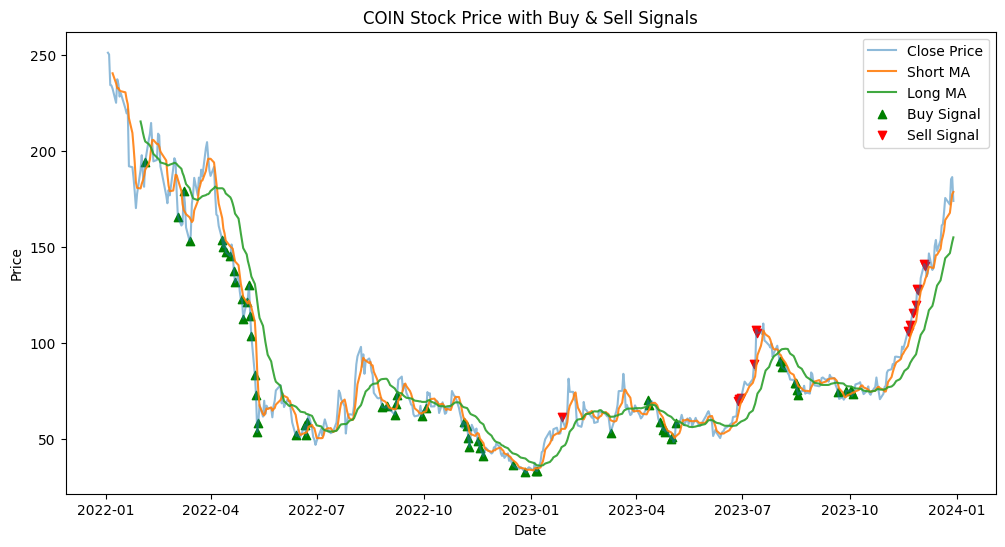

Analyzing TSLA...


[*********************100%%**********************]  1 of 1 completed

Buy signals for TSLA:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-02-18  295.333344  295.623322  279.203339  285.660004  285.660004   
2022-02-22  278.043335  285.576660  267.033325  273.843323  273.843323   
2022-02-23  276.809998  278.433319  253.520004  254.679993  254.679993   
2022-02-24  233.463333  267.493347  233.333328  266.923340  266.923340   
2022-03-08  265.176666  283.329987  260.723328  274.799988  274.799988   
2022-04-20  343.333344  344.666656  325.083344  325.733337  325.733337   
2022-04-26  331.809998  333.333344  291.666656  292.140015  292.140015   
2022-04-28  299.993347  300.000000  273.899994  292.503326  292.503326   
2022-05-05  313.006653  315.200012  285.899994  291.093323  291.093323   
2022-05-09  278.816681  281.876678  260.383331  262.369995  262.369995   
2022-05-11  265.000000  269.923340  242.399994  244.666672  244.666672   
2022-05-12  233

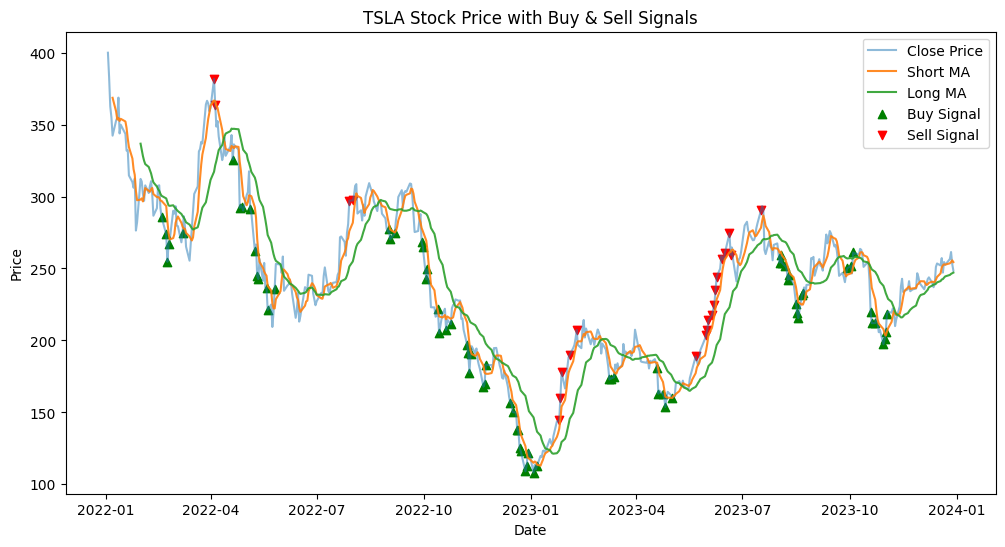

[*********************100%%**********************]  1 of 1 completed


Analyzing NVDA...
Buy signals for NVDA:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-03-07  228.169998  230.330002  213.300003  213.520004  213.262238   
2022-03-08  213.089996  223.729996  206.500000  215.139999  214.880295   
2022-03-09  223.869995  232.199997  222.470001  230.139999  229.862183   
2022-04-07  244.410004  247.220001  234.779999  242.080002  241.787766   
2022-04-08  239.169998  239.229996  230.619995  231.190002  230.910934   
2022-04-11  222.139999  223.199997  216.600006  219.169998  218.905426   
2022-04-12  225.369995  227.250000  212.820007  215.039993  214.780396   
2022-04-21  217.089996  223.919998  200.000000  201.830002  201.586334   
2022-04-22  203.029999  204.860001  195.000000  195.149994  194.914413   
2022-04-25  192.020004  199.449997  190.960007  199.020004  198.779770   
2022-04-26  197.179993  197.880005  186.699997  187.880005  187.653229 

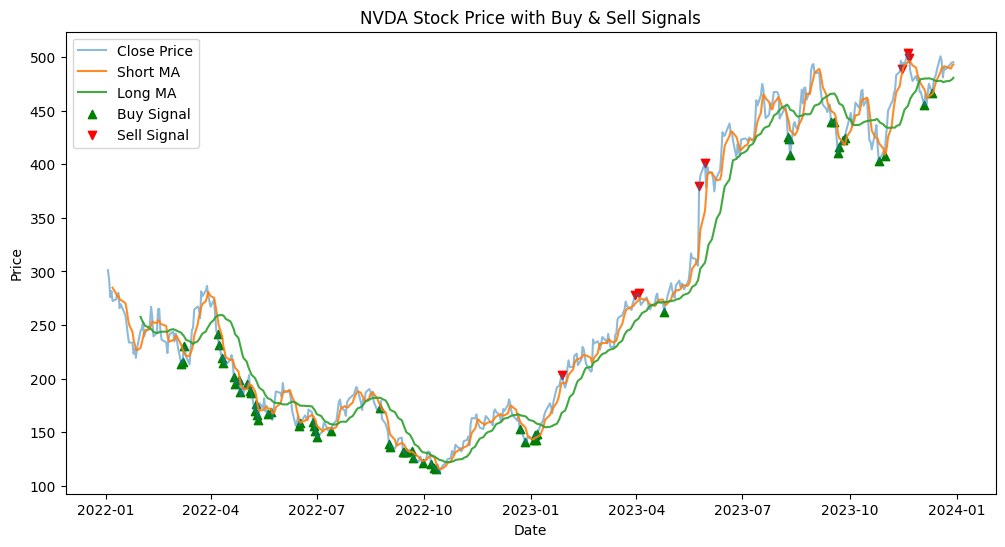

[*********************100%%**********************]  1 of 1 completed

Analyzing AMD...
Buy signals for AMD:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-02-01  116.750000  117.260002  112.730003  116.779999  116.779999   
2022-02-02  129.889999  130.059998  120.639999  122.760002  122.760002   
2022-02-23  117.400002  118.650002  109.040001  109.760002  109.760002   
2022-03-08  102.809998  109.900002  100.080002  105.529999  105.529999   
2022-04-08  102.510002  102.989998  100.419998  101.000000  101.000000   
2022-04-11   98.599998   98.669998   95.940002   97.370003   97.370003   
2022-04-21   95.160004   96.230003   89.239998   89.849998   89.849998   
2022-04-22   90.029999   91.459999   87.940002   88.139999   88.139999   
2022-04-25   89.860001   91.370003   88.610001   90.690002   90.690002   
2022-04-26   89.739998   90.120003   85.080002   85.160004   85.160004   
2022-04-28   86.669998   90.580002   84.779999   89.639999   89.639999   

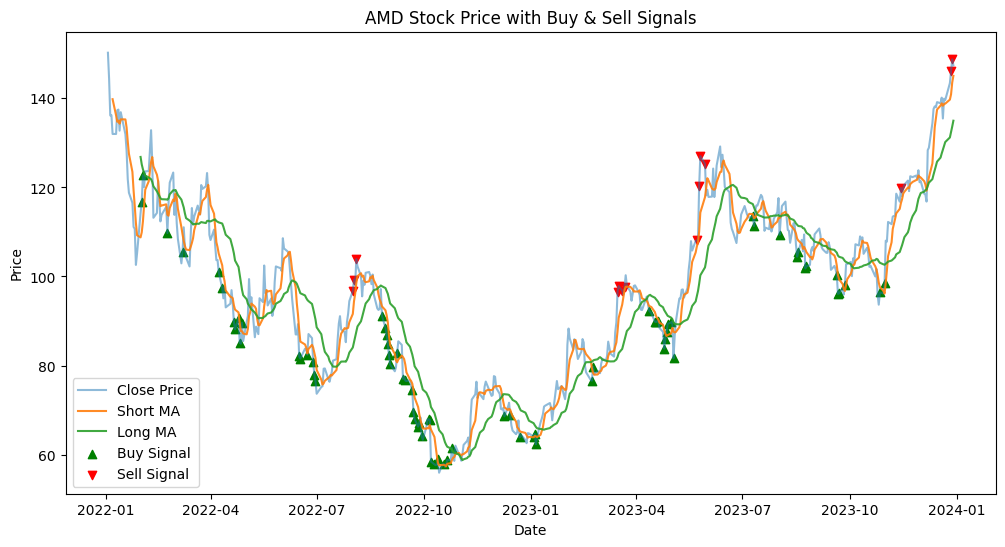

[*********************100%%**********************]  1 of 1 completed

Analyzing AAPL...
Buy signals for AAPL:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-02-22  164.979996  166.690002  162.149994  164.320007  162.670731   
2022-02-23  165.539993  166.149994  159.750000  160.070007  158.463409   
2022-02-24  152.580002  162.850006  152.000000  162.740005  161.106598   
2022-03-07  163.360001  165.020004  159.039993  159.300003  157.701126   
2022-03-08  158.820007  162.880005  155.800003  157.440002  155.859772   
2022-03-10  160.199997  160.389999  155.979996  158.520004  156.928925   
2022-03-14  151.449997  154.119995  150.100006  150.619995  149.108231   
2022-04-14  170.619995  171.270004  165.039993  165.289993  163.630981   
2022-04-21  168.910004  171.529999  165.910004  166.419998  164.749634   
2022-04-22  166.460007  167.869995  161.500000  161.789993  160.166122   
2022-04-25  161.119995  163.169998  158.460007  162.880005  161.245178 

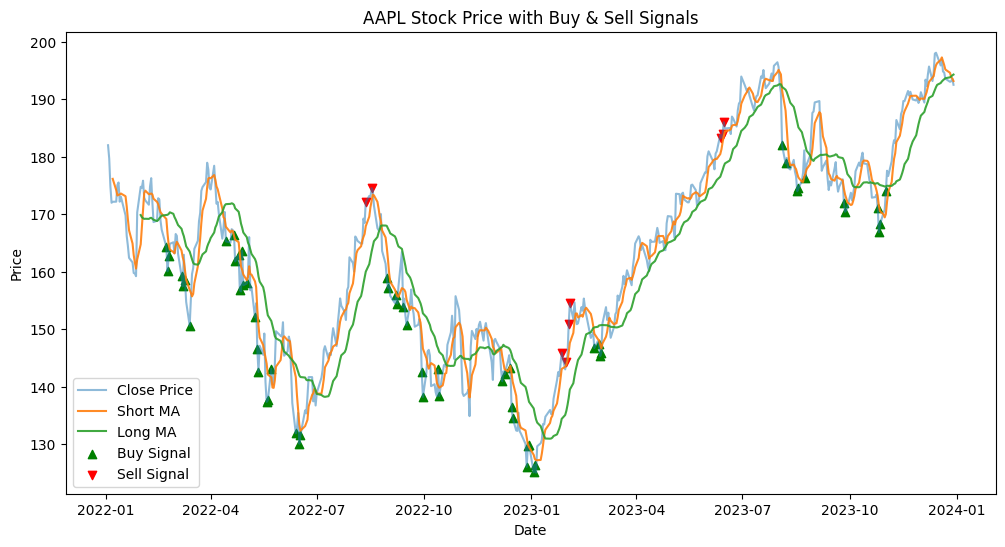

[*********************100%%**********************]  1 of 1 completed

Analyzing JPM...
Buy signals for JPM:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-02-28  143.550003  145.059998  140.880005  141.800003  133.459579   
2022-03-01  140.039993  140.479996  133.580002  136.449997  128.424225   
2022-03-07  132.169998  132.690002  128.949997  129.210007  121.610107   
2022-03-11  132.490005  134.080002  128.419998  128.889999  121.308907   
2022-04-12  132.139999  134.580002  130.699997  131.539993  124.720703   
2022-04-13  126.940002  129.250000  126.010002  127.300003  120.700516   
2022-04-14  126.500000  128.300003  125.019997  126.120003  119.581703   
2022-04-22  130.279999  130.520004  126.690002  126.809998  120.235924   
2022-04-25  126.010002  127.120003  123.110001  126.769997  120.197998   
2022-04-26  124.639999  126.410004  122.870003  123.019997  116.642403   
2022-04-27  122.330002  123.559998  121.220001  121.419998  115.125351   

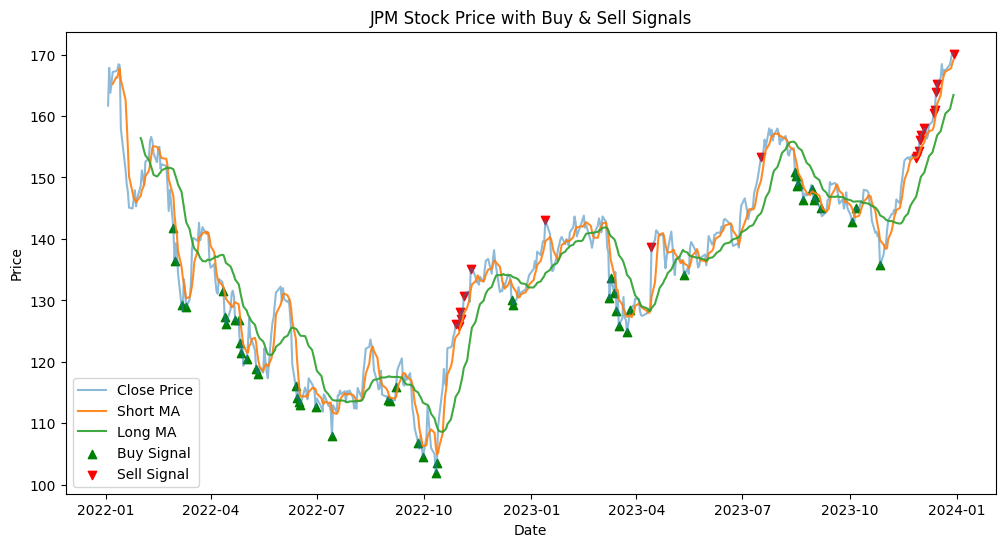

In [219]:

# Define a list of stock tickers
tickers = ['COIN', 'TSLA', 'NVDA', 'AMD', 'AAPL', 'JPM']

start_date = '2022-01-01'
end_date = '2024-01-01'

# Monitor each stock
for ticker in tickers:
    print(f"Analyzing {ticker}...")
    stock = get_stock_data(ticker, start_date, end_date)
    buy, sell = decide_trade(stock, short_window=5, long_window=20)

    # You can store these results in a data structure or database
    print(f"Buy signals for {ticker}:\n", stock[buy])
    print(f"Sell signals for {ticker}:\n", stock[sell])

    # Optional: Plotting
    plt.figure(figsize=(12,6))
    plt.plot(stock['Close'], label='Close Price', alpha=0.5)
    plt.plot(stock['Short_MA'], label='Short MA', alpha=0.9)
    plt.plot(stock['Long_MA'], label='Long MA', alpha=0.9)
    plt.scatter(stock.index[buy], stock['Close'][buy], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(stock.index[sell], stock['Close'][sell], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.title(f'{ticker} Stock Price with Buy & Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()

In [223]:

# Example usage
for ticker in tickers:
  stock = get_stock_data(ticker, start_date, end_date)
  buy, sell = decide_trade(stock, short_window=5, long_window=20, rsi_buy_signal= 40, rsi_sell_signal=90)
  trades, total_return, return_percentage = backtest_strategy(stock, buy, sell,30,0.1)
  print(f"#######################{ticker}##########################")
  print(f"Trades: {trades}")
  print(f"Total Return: ${total_return:.2f}")
  print(f"Return Percentage: {return_percentage:.2f}%")
  print(f"Hold Return Percentage: {(stock['Close'][len(stock)-1]-stock['Close'][0])/stock['Close'][0]*100:.2f}%")


[*********************100%%**********************]  1 of 1 completed


/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_10320/1649610018.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = stock_data['Close'][i]
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_10320/1649610018.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals[i] and balance >= current_price:
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_10320/1649610018.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

#######################COIN##########################
Trades: [('BUY', Timestamp('2022-02-04 00:00:00'), 194.44000244140625, 25.0), ('BUY', Timestamp('2022-03-04 00:00:00'), 165.75, 15.0), ('BUY', Timestamp('2022-03-09 00:00:00'), 178.97000122070312, 7.0), ('BUY', Timestamp('2022-03-14 00:00:00'), 153.19000244140625, 4.0), ('BUY', Timestamp('2022-04-11 00:00:00'), 153.8699951171875, 2.0), ('BUY', Timestamp('2022-04-12 00:00:00'), 149.85000610351562, 1.0), ('BUY', Timestamp('2022-04-14 00:00:00'), 147.2899932861328, 1.0), ('BUY', Timestamp('2022-05-09 00:00:00'), 83.51000213623047, 1.0), ('BUY', Timestamp('2022-11-09 00:00:00'), 45.97999954223633, 1.0), ('SELL', Timestamp('2023-07-11 00:00:00'), 89.1500015258789, 57.0), ('BUY', Timestamp('2023-08-02 00:00:00'), 90.43000030517578, 28.0), ('BUY', Timestamp('2023-08-03 00:00:00'), 90.75, 14.0), ('BUY', Timestamp('2023-08-04 00:00:00'), 87.30999755859375, 7.0), ('BUY', Timestamp('2023-08-15 00:00:00'), 79.18000030517578, 4.0), ('BUY', Times


/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_10320/1649610018.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = stock_data['Close'][i]
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_10320/1649610018.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signals[i] and balance >= current_price:
/var/folders/xp/6dcyx55d5833ps53x179mjpc0000gn/T/ipykernel_10320/1649610018.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

In [190]:
def get_stock_info_on_date(tickers, date=datetime.today().strftime("%Y-%m-%d"), history_days=600, long_term_ma=200, rsi_buy_signal=40, rsi_sell_signal=90):
    print("Today is " + date)
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=history_days)

    market_index = yf.Ticker("^GSPC")  # S&P 500 Index
    market_data = market_index.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    market_signal = get_market_exit_signal(market_data, long_term_ma)
    print(market_signal)

    data = {'Company Code': [], 'Recommendation': [], 'P/E Ratio': [], 'Recommended PE':[], 'Category': [],'Dividend Yield': [], 'Market Cap': [], 'Earnings Growth': []}
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist_data = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        if hist_data.empty:
            continue  # Skip if no data for the given date range

        # Apply buy/sell signal functions (as previously defined)
        buy_signal = check_buy_signal(hist_data,rsi_buy_signal=rsi_buy_signal)
        sell_signal = check_sell_signal(hist_data,rsi_sell_signal=rsi_sell_signal)
        recommendation = 'BUY' if buy_signal else 'SELL' if sell_signal else None

        if recommendation:
            pe_ratio = stock.info.get('trailingPE', 'N/A')
            category = stock.info.get('sector', 'N/A')
            dividend_yield = stock.info.get('dividendYield', 'N/A') * 100 if stock.info.get('dividendYield') is not None else 'N/A'
            market_cap = stock.info.get('marketCap', 'N/A')
            earnings_growth = stock.info.get('earningsGrowth', 'N/A')
            data['Company Code'].append(ticker)
            data['Recommendation'].append(recommendation)
            data['P/E Ratio'].append(pe_ratio)
            data['Category'].append(category)
            data['Dividend Yield'].append(dividend_yield)
            data['Market Cap'].append(market_cap)
            data['Earnings Growth'].append(earnings_growth)
            data['Recommended PE'].append(recommended_pe_ratio(category))

    return pd.DataFrame(data)


In [104]:
def get_sp500_tickers():
    # url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    # sp500_table = pd.read_html(url, header=0)[0]
    # tickers = sp500_table['Symbol'].tolist()
    # print(tickers)
    # return tickers
    return ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EG', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'FLT', 'FMC', 'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GEHC', 'GEN', 'GNRC', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VMC', 'WRB', 'WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WRK', 'WY', 'WHR', 'WMB', 'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']

sp500_tickers = get_sp500_tickers()

In [111]:
def get_nasdaq_tickers():
    # url = 'https://en.wikipedia.org/wiki/NASDAQ-100'
    # tables = pd.read_html(url)  # Scrapes all tables from the Wikipedia page
    # nasdaq_table = tables[4]  # The table with NASDAQ tickers is typically the fourth table on the page
    # nasdaq_tickers = nasdaq_table['Ticker'].tolist()  # Extracts the tickers into a list
    # return nasdaq_tickers
    return ['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']

nasdaq_tickers = get_nasdaq_tickers()
print(nasdaq_tickers)

# Stock Filter

In [282]:
# Rules
def rule_price_above_moving_averages(stock_data):
    """Price and 50-day MA higher than both 150-day and 200-day MAs."""
    ma50 = stock_data['Close'].rolling(window=50).mean()
    ma150 = stock_data['Close'].rolling(window=150).mean()
    ma200 = stock_data['Close'].rolling(window=200).mean()
    current_price = stock_data['Close'].iloc[-1]
    # print(current_price)
    # print(ma50.iloc[-1])
    # print(ma150.iloc[-1])
    # print(ma200.iloc[-1])
    return current_price > ma150.iloc[-1] and current_price > ma200.iloc[-1] and ma50.iloc[-1] > ma150.iloc[-1] and ma150.iloc[-1] > ma200.iloc[-1]

def rule_ma200_uptrend(stock_data, days=30):
    """200-day MA has been in an uptrend for at least 'days' days."""
    ma200 = stock_data['Close'].rolling(window=200).mean()
    # print(ma200.iloc[-1] > ma200.iloc[-days])
    return ma200.iloc[-1] > ma200.iloc[-days]

def rule_price_above_52week_low(stock_data, threshold=0.25):
    """Current price is at least 'threshold' % higher than the 52-week low."""
    low_52week = stock_data['Close'].rolling(window=252).min().iloc[-1]
    current_price = stock_data['Close'].iloc[-1]
    # print(current_price >= low_52week * (1 + threshold))
    return current_price >= low_52week * (1 + threshold)

def rule_price_near_52week_high(stock_data, threshold=0.25):
    """Current price is within 'threshold' % of the 52-week high."""
    high_52week = stock_data['Close'].rolling(window=252).max().iloc[-1]
    current_price = stock_data['Close'].iloc[-1]
    # print(current_price >= high_52week * (1 - threshold))
    return current_price >= high_52week * (1 - threshold)

In [302]:
def stock_filter(tickers, rules,date = datetime.today().strftime("%Y-%m-%d")):
    filtered_stocks = []
    for ticker in tickers:
        end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
        min_history_days = 3*365
        start_date = end_date - timedelta(days=min_history_days)
        try:
            data = yf.download(ticker, start=start_date, end=date)
            if all(rule(data) for rule in rules):
                filtered_stocks.append(ticker)
            else:
                print(ticker + ' is not recommended to trade')
        except:
            continue
    return filtered_stocks

In [288]:
filter_rules = [
    rule_price_above_moving_averages,
    rule_ma200_uptrend,
    rule_price_above_52week_low,
    rule_price_near_52week_high
]

# List of tickers
# tickers = ['AAPL','AMD','ARKK','ARM','BA', 'BABA','BAC','BILI','BNTX', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DDOG', 'DIS', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'MDB','META', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PDD', 'PLTR', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'TMF', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'WFC','XOM']
# tickers = nasdaq_tickers
tickers=['AAPL',"NVDA","TSLA","MSFT","COIN"]
# Apply the filter
filtered_stocks = stock_filter(tickers, filter_rules, date="2023-04-01")
print("Stocks that meet the criteria:", filtered_stocks)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

AAPL is not recommended to trade
TSLA is not recommended to trade
MSFT is not recommended to trade
Stocks that meet the criteria: ['NVDA']


In [308]:
def test_stock_filter_performance(tickers, rules, start_date, end_date):
    passed_stocks = stock_filter(tickers, rules, end_date)
    failed_stocks = set(tickers) - set(passed_stocks)

    return calculate_average_return(passed_stocks, start_date, end_date), calculate_average_return(failed_stocks, start_date, end_date), passed_stocks, failed_stocks

def calculate_average_return(stocks, start_date, end_date):
    returns = []
    annualized_returns = []
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    days_in_period = (end - start).days
    for ticker in stocks:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            
            if not stock_data.empty:
                initial_price = stock_data['Close'].iloc[0]
                final_price = stock_data['Close'].iloc[-1]
                stock_return = (final_price - initial_price) / initial_price
                annualized_return = (1 + stock_return) ** (365.0 / days_in_period) - 1
                returns.append(stock_return)
                annualized_returns.append(annualized_return)
        except:
            continue
    if returns:
        return sum(returns) / len(returns), sum(annualized_returns)/len(annualized_returns)
    else:
        return None

# Example usage
tickers = nasdaq_tickers
start_date = "2023-04-01"
end_date = '2023-07-01'

average_return_passed, average_return_failed, passed_stocks, failed_stocks = test_stock_filter_performance(tickers, filter_rules, start_date, end_date)
print("Average yearly Return of Passed Stocks:", average_return_passed[1], "Number of Passed Stocks: ", len(passed_stocks))
print("Average yearly Return of Failed Stocks:", average_return_failed[1], "Number of Failed Stocks: ", len(failed_stocks))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMZN is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TEAM is not recommended to trade
ADSK is not recommended to trade
BKR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BIIB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


CDW is not recommended to trade
CHTR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


CSCO is not recommended to trade
CTSH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


CEG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


COST is not recommended to trade
CRWD is not recommended to trade
CSX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


DDOG is not recommended to trade
FANG is not recommended to trade
DLTR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


EA is not recommended to trade
EXC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


GEHC is not recommended to trade
GILD is not recommended to trade
GFS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


HON is not recommended to trade
ILMN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


INTC is not recommended to trade
INTU is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


KDP is not recommended to trade
KHC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


MRNA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ODFL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


PAYX is not recommended to trade
PYPL is not recommended to trade
PDD is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


PEP is not recommended to trade
QCOM is not recommended to trade
REGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ROST is not recommended to trade
SIRI is not recommended to trade
SPLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


SBUX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TMUS is not recommended to trade
TSLA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TXN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


WBA is not recommended to trade
WBD is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


XEL is not recommended to trade
ZS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Average yearly Return of Passed Stocks: 1.0653943913727937 Number of Passed Stocks:  52
Average yearly Return of Failed Stocks: 0.15782886540702631 Number of Failed Stocks:  49


In [325]:

def closest_trading_date(data, date):
    """Find the closest previous trading date in the data for a given date."""
    if date in data.index:
        return date
    # Iterate backwards to find the closest previous date
    while date not in data.index:
        date -= pd.Timedelta(days=1)
    return date

def test_filter_performance_over_periods(tickers, rules, start_date, end_date):
  
    # Generate dates at regular intervals between start and end
    date_range = pd.date_range(start=start_date, end=end_date, freq='M')
    
    # Lists to store results
    filtered_returns = []
    unfiltered_returns = []
    differences = []
    sp500_returns = []

    sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close']
    
    for date in date_range:
        trading_date = closest_trading_date(sp500, date)

        filtered_stocks = stock_filter(tickers, rules, date.strftime('%Y-%m-%d'))
        unfiltered_stocks = set(tickers) - set(filtered_stocks)

        filtered_avg_return, _ = calculate_average_return(filtered_stocks, start_date, date.strftime('%Y-%m-%d'))
        unfiltered_avg_return, _ = calculate_average_return(unfiltered_stocks, start_date, date.strftime('%Y-%m-%d'))

        sp500_return = (sp500.loc[trading_date] - sp500[0]) / sp500[0]

        filtered_returns.append(filtered_avg_return if filtered_avg_return is not None else 0)
        unfiltered_returns.append(unfiltered_avg_return if unfiltered_avg_return is not None else 0)
        differences.append((filtered_avg_return - unfiltered_avg_return) if filtered_avg_return is not None and unfiltered_avg_return is not None else 0)
        sp500_returns.append(sp500_return)

    return date_range, filtered_returns, unfiltered_returns, differences, sp500_returns


start_date = '2022-05-01'
end_date = '2024-01-01'
tickers = sp500_tickers[25:75]
date_range, filtered_returns, unfiltered_returns, differences, sp500_returns = test_filter_performance_over_periods(tickers, filter_rules, start_date, end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade
AMT is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AWK is not recommended to trade
AMP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AME is not recommended to trade
APH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADI is not recommended to trade
ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL is not recommended to trade
AMAT is not recommended to trade
APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANET is not recommended to trade
AJG is not recommended to trade
AIZ is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


T is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade
BK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBWI is not recommended to trade
BAX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BDX is not recommended to trade
BBY is not recommended to trade
BIO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TECH is not recommended to trade
BIIB is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BX is not recommended to trade
BA is not recommended to trade
BKNG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BWA is not recommended to trade
BXP is not recommended to trade
BSX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade
AMT is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AWK is not recommended to trade
AMP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


AME is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade
APH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADI is not recommended to trade
ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade
APA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL is not recommended to trade
AMAT is not recommended to trade
APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ACGL is not recommended to trade
ADM is not recommended to trade
ANET is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AJG is not recommended to trade
AIZ is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


T is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade
BKR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BIIB is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BX is not recommended to trade
BA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKNG is not recommended to trade
BWA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade
BSX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade
AMP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AME is not recommended to trade
AMGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APH is not recommended to trade
ADI is not recommended to trade
ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade
APA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL is not recommended to trade
AMAT is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APTV is not recommended to trade
ACGL is not recommended to trade
ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANET is not recommended to trade
AJG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADSK is not recommended to trade
ADP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVB is not recommended to trade
AVY is not recommended to trade
AXON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKR is not recommended to trade
BALL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BAC is not recommended to trade
BK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBWI is not recommended to trade
BAX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BDX is not recommended to trade
BBY is not recommended to trade
BIO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TECH is not recommended to trade
BIIB is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BX is not recommended to trade
BA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKNG is not recommended to trade
BWA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade
BSX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade
AMP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AME is not recommended to trade
AMGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APH is not recommended to trade
ADI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANSS is not recommended to trade
AON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

APA is not recommended to trade
AAPL is not recommended to trade



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMAT is not recommended to trade
APTV is not recommended to trade
ACGL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade
ANET is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADSK is not recommended to trade
ADP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVB is not recommended to trade
AVY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXON is not recommended to trade
BKR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade
BIIB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BLK is not recommended to trade
BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BA is not recommended to trade
BKNG is not recommended to trade
BWA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade
BSX is not recommended to trade
BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMP is not recommended to trade
AME is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade
APH is not recommended to trade
ADI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANSS is not recommended to trade
AON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APA is not recommended to trade
AAPL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMAT is not recommended to trade
APTV is not recommended to trade
ACGL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade
ANET is not recommended to trade
AJG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade
BKR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BIIB is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BX is not recommended to trade
BA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKNG is not recommended to trade
BWA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade
BSX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMP is not recommended to trade
AME is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade
APH is not recommended to trade
ADI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANSS is not recommended to trade
AON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL is not recommended to trade
AMAT is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APTV is not recommended to trade
ACGL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANET is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade
BKR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BLK is not recommended to trade
BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BA is not recommended to trade
BKNG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BWA is not recommended to trade
BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BSX is not recommended to trade
BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade
AMP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AME is not recommended to trade
APH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADI is not recommended to trade
ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL is not recommended to trade
AMAT is not recommended to trade
APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANET is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


BKR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBWI is not recommended to trade
BAX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed


BDX is not recommended to trade
BBY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BLK is not recommended to trade
BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BA is not recommended to trade
BKNG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


BWA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade
BSX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMP is not recommended to trade
AME is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APH is not recommended to trade
ADI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APA is not recommended to trade
AAPL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMAT is not recommended to trade
APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade
ANET is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


BKR is not recommended to trade
BALL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BAC is not recommended to trade
BK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBWI is not recommended to trade
BAX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BDX is not recommended to trade
BBY is not recommended to trade
BIO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TECH is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

BX is not recommended to trade
BA is not recommended to trade



[*********************100%%**********************]  1 of 1 completed


BKNG is not recommended to trade
BWA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade
BSX is not recommended to trade
BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade
ADI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANSS is not recommended to trade
AON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APA is not recommended to trade
AAPL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMAT is not recommended to trade
APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade
ANET is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKR is not recommended to trade
BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BLK is not recommended to trade
BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKNG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade
AMT is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade
APH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANSS is not recommended to trade
AON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APA is not recommended to trade
AAPL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMAT is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AJG is not recommended to trade
AIZ is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


T is not recommended to trade
ATO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADSK is not recommended to trade
ADP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVB is not recommended to trade
AVY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKR is not recommended to trade
BALL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BAC is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BLK is not recommended to trade
BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade
BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMP is not recommended to trade
AMGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APA is not recommended to trade
AAPL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVB is not recommended to trade
AVY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKR is not recommended to trade
BALL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BAC is not recommended to trade
BK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBWI is not recommended to trade
BAX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BDX is not recommended to trade
BBY is not recommended to trade
BIO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TECH is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade
AMT is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AWK is not recommended to trade
AMP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade
APH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APA is not recommended to trade
AAPL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKR is not recommended to trade
BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TECH is not recommended to trade
BIIB is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade
APH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APA is not recommended to trade
AAPL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APTV is not recommended to trade
ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AZO is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
BKR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BLK is not recommended to trade
BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AEP is not recommended to trade
AXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIG is not recommended to trade
AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

AMGN is not recommended to trade
APH is not recommended to trade



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AZO is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade
BKR is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BIIB is not recommended to trade
BLK is not recommended to trade
BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AEP is not recommended to trade
AXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIG is not recommended to trade
AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade
APA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APTV is not recommended to trade
ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AZO is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade
BAX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BIIB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADI is not recommended to trade
AON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AZO is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

BK is not recommended to trade
BBWI is not recommended to trade



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade
TECH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BIIB is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BWA is not recommended to trade
BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

AMT is not recommended to trade
AWK is not recommended to trade



[*********************100%%**********************]  1 of 1 completed


AMP is not recommended to trade
AME is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADI is not recommended to trade
ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade
APA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL is not recommended to trade
APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AIZ is not recommended to trade
T is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ATO is not recommended to trade
ADSK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AZO is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TECH is not recommended to trade
BIIB is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BA is not recommended to trade
BWA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade
AIG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMP is not recommended to trade
AME is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMGN is not recommended to trade
APH is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADI is not recommended to trade
ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade
APA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL is not recommended to trade
AMAT is not recommended to trade
APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


T is not recommended to trade
ATO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADSK is not recommended to trade
ADP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


AZO is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


BAX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed


BDX is not recommended to trade
BBY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BIO is not recommended to trade
TECH is not recommended to trade
BIIB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BLK is not recommended to trade
BX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BA is not recommended to trade
BKNG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BWA is not recommended to trade
BXP is not recommended to trade
BSX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMP is not recommended to trade
AME is not recommended to trade
AMGN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APH is not recommended to trade
ADI is not recommended to trade
ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade
APA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AAPL is not recommended to trade
APTV is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


T is not recommended to trade
ATO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADSK is not recommended to trade
ADP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AZO is not recommended to trade
AVB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVY is not recommended to trade
AXON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


BKR is not recommended to trade
BALL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BAC is not recommended to trade
BK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


BBWI is not recommended to trade
BAX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BDX is not recommended to trade
BBY is not recommended to trade
BIO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TECH is not recommended to trade
BIIB is not recommended to trade
BLK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BWA is not recommended to trade
BXP is not recommended to trade
BSX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

AAL is not recommended to trade
AEP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AMT is not recommended to trade
AWK is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AME is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADI is not recommended to trade
ANSS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AON is not recommended to trade
APA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


APTV is not recommended to trade
ACGL is not recommended to trade
ADM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AJG is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


T is not recommended to trade
ATO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ADP is not recommended to trade
AZO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


AVB is not recommended to trade
AXON is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BKR is not recommended to trade
BALL is not recommended to trade
BAC is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BK is not recommended to trade
BBWI is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


BAX is not recommended to trade
BDX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BBY is not recommended to trade
BIO is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TECH is not recommended to trade
BIIB is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BWA is not recommended to trade
BXP is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BMY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

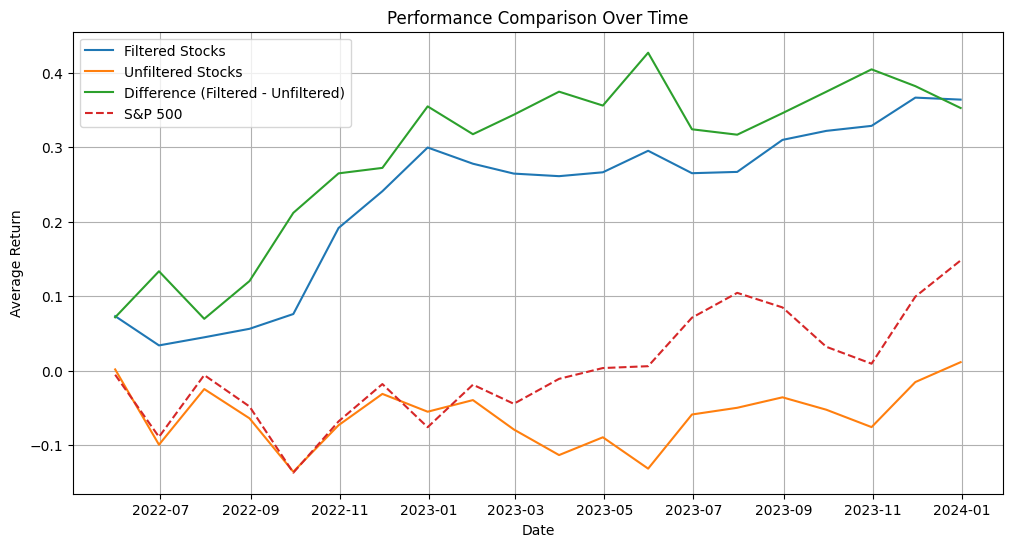

In [326]:
plt.figure(figsize=(12, 6))
plt.plot(date_range, filtered_returns, label='Filtered Stocks')
plt.plot(date_range, unfiltered_returns, label='Unfiltered Stocks')
plt.plot(date_range, differences, label='Difference (Filtered - Unfiltered)')
plt.plot(date_range, sp500_returns, label='S&P 500', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Average Return')
plt.title('Performance Comparison Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Stock Warning

In [250]:
def rule_price_increase(stock_data):
    """Rule 2: 25-50% increase in 1 to 3 weeks."""
    period_returns = stock_data['Close'].pct_change(periods=5).iloc[-1]  # 1-week return
    return 0.25 <= period_returns <= 0.50

def rule_largest_gain(stock_data):
    """Rule 3: Largest single-day gain since rise began."""
    daily_gains = stock_data['Close'].pct_change()
    max_gain = daily_gains.max()
    recent_gain = daily_gains.iloc[-1]
    return recent_gain == max_gain

def rule_accelerating_growth(stock_data):
    """Rule 6: 6-10 days of accelerating growth, with only about 2 days of decline."""
    recent_data = stock_data['Close'].iloc[-10:]
    up_days = recent_data.pct_change() > 0
    return up_days.sum() >= 8

def rule_falling_below_ma(stock_data):
    """Rule 10: Falling below 50-day MA on largest volume."""
    ma50 = stock_data['Close'].rolling(window=50).mean().iloc[-1]
    max_volume = stock_data['Volume'].max()
    recent_volume = stock_data['Volume'].iloc[-1]
    current_price = stock_data['Close'].iloc[-1]
    return current_price < ma50 and recent_volume == max_volume

In [253]:
def stock_warning_system(tickers, date, rules):
    warnings = {}
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=365)
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=date)
        for rule in rules:
            if rule(data):
                warnings.setdefault(ticker, []).append(rule.__name__)
    return warnings

In [258]:
# Define your rules
warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]  # Add other rule functions here

# List of tickers and a specific date
# tickers = ['AAPL', 'MSFT', 'GOOG']
tickers = nasdaq_tickers
date = '2024-01-03'  # Replace with your date

# Get warnings
warnings = stock_warning_system(tickers, date, warning_rules)
print("Warnings:", warnings)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {'MRNA': ['rule_largest_gain'], 'MNST': ['rule_accelerating_growth']}


# Everyday

In [290]:
# Example usage
# tickers = get_nasdaq_tickers() # List of tickers
# tickers = get_sp500_tickers()

tickers = ['AAPL','AMD', 'ALK', 'ARKK','ARM','BABA','BAC','BILI','BNTX', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DDOG', 'DIS', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'MDB','META', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'WFC','XOM']
filter_rules = [
    rule_price_above_moving_averages,
    rule_ma200_uptrend,
    rule_price_above_52week_low,
    rule_price_near_52week_high
]
filtered_tickers = stock_filter(tickers, filter_rules)
print(filtered_tickers)
date = datetime.today().strftime("%Y-%m-%d")
# date = '2024-01-06'
stock_table = get_stock_info_on_date(filtered_tickers, date,rsi_buy_signal=40,rsi_sell_signal=90)


warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]
warnings = stock_warning_system(tickers, date, warning_rules)
print("Warnings:", warnings)


# Set the display.max_rows option to None
pd.set_option('display.max_rows', None)
display(stock_table)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ALK is not recommended to trade
ARM is not recommended to trade
BABA is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


BILI is not recommended to trade
BNTX is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


COIN is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


DIS is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


KO is not recommended to trade
KRE is not recommended to trade
LYFT is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


NKE is not recommended to trade
ORCL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


OXY is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


PFE is not recommended to trade
RBLX is not recommended to trade
SAVE is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


SOFI is not recommended to trade
TMF is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


TRV is not recommended to trade
TSLA is not recommended to trade
TSM is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


UAL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


UHAL is not recommended to trade


[*********************100%%**********************]  1 of 1 completed


XOM is not recommended to trade
['AAPL', 'AMD', 'ARKK', 'BAC', 'COF', 'COST', 'CRM', 'DASH', 'DDOG', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'MDB', 'META', 'MSFT', 'NVDA', 'PDD', 'PLTR', 'SHOP', 'SNOW', 'UBER', 'WFC']
Today is 2024-01-15
Stay


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Warnings: {}


,Company Code,Recommendation,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth
0,HOOD,BUY,N/A,"(N/A, N/A)",Financial Services,N/A,9529897984,N/A
1,WFC,BUY,9.813665,"(N/A, N/A)",Financial Services,2.95,170585964544,0.284
